# DOCUMENTATION

1. Import relevant libraries and download relevant resources
2. Obtain the details for retrieving and stroing the data
3. Get the dataset from mongoDB database and store it as a pandas dataframe. <br/>
4. Reduce the orginial dataframe by removing the columns which are not needed for Topic Modelling. Cureently we are considering only the area and the description of the project as the columns in our dataframe. 
5. Identifying stopwords:
    5.1. Load NLTK's English and German stopwords
    5.2. Add cities and mothns to it 
    5.3. Manually added stopwords (irrelevant words for our analysis)
6. Creation of Stemmer: Creating our own stemmer as a dictionary where we specify how to combine same words
7. Tokenzing and Stemming the description data present in the dataframe.
8. Get frequency distribution of all words present in the dataframe.
9. Choose a threshold frequency for top words(currently 100)
10. Reduce the words in tokenized column to these top words for each row
11. Remove the rows which have less than 10 tokens
12. Create training and test dataset
13. Train LDA model
14. Save the model as 'LDA_Approach_1.model'

### Importing all the relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from nltk.tokenize import word_tokenize
import pickle
import string
from string import punctuation
import os
%matplotlib inline
sns.set_style("darkgrid")

### Set the current directory where this notebook is present as working Directory

In [2]:
currDir = os.getcwd()
if "USL" not in currDir:
    os.chdir(os.path.join(currDir,  "ML", "USL"))
print("Current directory is: " + currDir)

Current directory is: /opt/jupyter/Icxa/projectfinder_analytics/ML/USL


### Database details for retrieving dataset and storing the dataset

In [3]:
#Details for retrieving  data from projectfinder
db_loc = {
    'ip' :'10.10.250.0',
    'port' : 27017,
    'database' : 'projectfinder',
    'collection' : 'itproject_clean'
}

In [4]:
#Details for storing data related to projectfinder
db_data = {
    'ip' :'10.10.250.0',
    'port' : 27017,
    'database' : 'projectfinder',
    'collection' : 'mldata1'
}

In [5]:
from script_files import load_save_dataset as load_save_DS

In [6]:
df_rawData = load_save_DS.load_dataset_from_mongodb(db_loc)
df_rawData.shape

Data loaded from mongodb itproject_clean collection succesfully


(14059, 25)

In [7]:
def get_required_dataset(original_dataset):
    
    #Select required colunms
    df = original_dataset[['description', 'bereich']]
    df = df[df['description'] != '']
    #df.rename(columns = {'description' : 'project', 'bereich' : 'class'})
    df['project'] = df['description']
    df['label'] = df['bereich']
    df.drop(['description', 'bereich'], axis=1, inplace=True)
    df = df[df['label'] != 'IT/Bauingenieur']
    df = df.drop_duplicates()
    return df

In [8]:
df_preprocessedDataset = get_required_dataset(df_rawData)
df_preprocessedDataset.shape
df_preprocessedDataset.head()

,project,label
0,Für einen unserer Kunden aus dem Finanzdienstl...,Infr-Admin-Microsoft
1,Kann Profil leider nicht löschen.,IT/Consulting
2,Business Intelligence Analyst (m/w) - Tableau ...,Data-Sci-BI
3,"Konzeption, Customizing sowie Softwareanpassun...",Infr-Admin-Linux
4,Es sollen mehrere Automatisierungen mit ubot S...,IT/IT


In [9]:
# shuffle the data
df_preprocessedDataset = df_preprocessedDataset.sample(frac=1.0)
df_preprocessedDataset.reset_index(drop=True,inplace=True)
df_preprocessedDataset.head()

,project,label
0,Für unseren Kunden in Hamburg suchen wir einen...,Infr-Admin-Microsoft
1,"Für unseren Kunden in Leipzig, Sachsen suchen ...",IT/Konstruktion
2,Projektbeschreibung \n\n ...,ERP-SAP
3,"Design, Konzeption und Umsetzung von SAP Busin...",Data-Sci-BI
4,Projektbeschreibung \n\n ...,Infr-Admin-Microsoft


In [10]:
df_preprocessedDataset.iloc[0,0]

'Für unseren Kunden in Hamburg suchen wir einen IT-Admin (m/w). \n \n \nKundendetails \n \n* Start: zeitnah \n * Dauer: 6 Monate \n * Auslastung: 4-5 Tage/Woche \n \n \nStellenbeschreibung \n \n* Betreuung/Beratung der Mitarbeiter im IT-Umfeld \n * Verantwortung für das Software Deployment und das Imaging unserer Clients \n * Planung und Durchführung von IMAC-Prozessen \n * Assetmanagement \n * Dokumentation im Ticketsystem \n \n \nProfil \n \n* Mehrjährige Berufserfahrung im Bereich IT-Support sowie -Infrastruktur \n * Erfahrung im Support von Microsoft-Produkten (Windows, Office, etc.), Skripterstellung und mit IT-Ticketsystemen \n * Kenntnisse in der Administration von Microsoft-Systemen (Fileserver, Active Directory, Exchange) \n * Serviceorientierte Denk- und Arbeitsweise \n * Erfahrung im Projektmanagement kleiner bis mittlerer IT-Projekte \n \n \nDas Angebot \n \nIch freue mich auf Ihre Rückmeldung.'

### Loadng stopwords and stemmer 

In [11]:
dataDir = os.path.join(currDir,  "constants")
stopwordsLocation = os.path.join(dataDir, "stopwords.pickle")
pickle_in = open(stopwordsLocation,"rb")
stopwords_all = pickle.load(pickle_in)

In [12]:
stemmerLocation = os.path.join(dataDir, "stemmer_own.pickle")
pickle_in = open(stemmerLocation,"rb")
stemmer_own = pickle.load(pickle_in)

### Perform tokenization, stemming on the text

In [13]:
def tokenize(text):
    """Normalize, tokenize and stem text string
    
    Args:
    text: string. String containing message for processing
       
    Returns:
    cleaned: list of strings. List containing normalized and stemmed word tokens
    """

    try:
        text = re.sub(r'(\d)',' ',text.lower())
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        tokens = word_tokenize(text)
        tokens_cleaned = [word for word in tokens if word not in stopwords_all and len(word) > 1]
        cleaned = []
        stemmer_keys = list(stemmer_own.keys())
        for word in tokens_cleaned:
            for stemmer_key in stemmer_keys:
                if stemmer_key in word:
                    stemmed_word = stemmer_own[stemmer_key]
                    cleaned.append(stemmed_word)
                    break
            else:
                cleaned.append(word)
  
                

    except IndexError:
        pass

    return cleaned

In [14]:
# Clean text and title and create new column "tokenized"
t1 = time.time()
df_preprocessedDataset['tokenized'] = df_preprocessedDataset['project'].apply(tokenize)
t2 = time.time()

In [15]:
print("Time taken to prepare", len(df_preprocessedDataset), "projects documents:", (t2-t1)/60, "min")

Time taken to prepare 12168 projects documents: 7.716735045115153 min


In [16]:
df_preprocessedDataset.head()

,project,label,tokenized
0,Für unseren Kunden in Hamburg suchen wir einen...,Infr-Admin-Microsoft,"[administration, kundendetails, berater, veran..."
1,"Für unseren Kunden in Leipzig, Sachsen suchen ...",IT/Konstruktion,"[erfahrene, engineer, rohrleitungskonstruktion..."
2,Projektbeschreibung \n\n ...,ERP-SAP,"[berater, cio, analyst, lösungsalternativen, f..."
3,"Design, Konzeption und Umsetzung von SAP Busin...",Data-Sci-BI,"[design, sap, business, intelligence, berater,..."
4,Projektbeschreibung \n\n ...,Infr-Admin-Microsoft,"[längerem, beidseitiger, zufriedenheit, active..."


### Identify most frequently occuring words

In [17]:
# Create a list containing all the words in a dataframe
all_words_df = [word for item in list(df_preprocessedDataset['tokenized']) for word in item]

# Use nltk fdist to get a frequency distribution of all words
fdist_words = FreqDist(all_words_df)
print(len(fdist_words)) # number of unique words
print(type(fdist_words))

#print(fdist_words.items())

40266
<class 'nltk.probability.FreqDist'>


In [18]:
total_unique_words = len(fdist_words)
sorted_freqDist_words = fdist_words.most_common()
maxFreq = sorted_freqDist_words[0][1]
print(maxFreq)
freq_values = [sorted_freqDist_words[i][1] for i in range(total_unique_words)]
avgFreq = np.mean(freq_values)
print(avgFreq)

22376
16.67309889236577


In [19]:
#Considering words with frequency of 100 or more
top_words = [sorted_freqDist_words[i][0] for i in range(total_unique_words) if sorted_freqDist_words[i][1] >= 100]
print(len(top_words))
#print(top_words)

878


In [20]:
def most_appeared(text):
    return [word for word in text if word in top_words]

In [21]:
#Reduce the words in tokenized column to the words with frequency more than 100. 
df_preprocessedDataset['tokenized'] = df_preprocessedDataset['tokenized'].apply(most_appeared)

In [22]:
df_preprocessedDataset.head(20)

,project,label,tokenized
0,Für unseren Kunden in Hamburg suchen wir einen...,Infr-Admin-Microsoft,"[administration, kundendetails, berater, veran..."
1,"Für unseren Kunden in Leipzig, Sachsen suchen ...",IT/Konstruktion,"[erfahrene, engineer, interface, daten, intern..."
2,Projektbeschreibung \n\n ...,ERP-SAP,"[berater, analyst, process, berater, planung, ..."
3,"Design, Konzeption und Umsetzung von SAP Busin...",Data-Sci-BI,"[design, sap, business, intelligence, berater,..."
4,Projektbeschreibung \n\n ...,Infr-Admin-Microsoft,"[active, dns, mm, active, analyst, process, ad..."
5,Projektbeschreibung \n\n ...,IT-Security,"[security, netzwerk, planung, implementation, ..."
6,Ihre Aufgaben: \nAnalyse und Ableitung von Tes...,Dev-Web-Fullstack,"[analyst, specification, normen, kundenanforde..."
7,Projektbeschreibung \n\n ...,Dev-Web-Fullstack,"[senior, java, entwicklung, entwicklung, innov..."
8,Für unseren Kunden suchen wir einen SAP Projek...,IT-Mgmt-Projectleiter,"[sap, management, kundendetails, management, p..."
9,Projektbeschreibung \n\n ...,ERP-SAP,"[key, sap, crm, berater, sap, crm, interaction..."


In [23]:
# only keep articles with more than 10 tokens, otherwise too short
df_preprocessedDataset = df_preprocessedDataset[df_preprocessedDataset['tokenized'].map(len) >= 10]
# make sure all tokenized items are lists
df_preprocessedDataset = df_preprocessedDataset[df_preprocessedDataset['tokenized'].map(type) == list]
df_preprocessedDataset.reset_index(drop=True,inplace=True)

In [24]:
print("After cleaning and excluding short aticles, the dataframe now has:", len(df_preprocessedDataset), "articles")

After cleaning and excluding short aticles, the dataframe now has: 11024 articles


### Split data to training and testing 

In [25]:
# create a mask of binary values to split into train and test
msk = np.random.rand(len(df_preprocessedDataset)) < 0.9960
msk

array([ True,  True,  True, ...,  True,  True,  True])

In [26]:
train_df = df_preprocessedDataset[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df_preprocessedDataset[~msk]
test_df.reset_index(drop=True,inplace=True)

In [27]:
train_df.head()

,project,label,tokenized
0,Für unseren Kunden in Hamburg suchen wir einen...,Infr-Admin-Microsoft,"[administration, kundendetails, berater, veran..."
1,"Für unseren Kunden in Leipzig, Sachsen suchen ...",IT/Konstruktion,"[erfahrene, engineer, interface, daten, intern..."
2,Projektbeschreibung \n\n ...,ERP-SAP,"[berater, analyst, process, berater, planung, ..."
3,"Design, Konzeption und Umsetzung von SAP Busin...",Data-Sci-BI,"[design, sap, business, intelligence, berater,..."
4,Projektbeschreibung \n\n ...,Infr-Admin-Microsoft,"[active, dns, mm, active, analyst, process, ad..."


### Train the LDA model on training data

In [28]:
def train_lda(data, n=10):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = n
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df_preprocessedDataset), "documents: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [29]:
dictionary,corpus,lda = train_lda(train_df, 10)

Time to train LDA model on  11024 documents:  0.3840420007705688 min


In [32]:
outputDir = os.path.join(currDir,  "output", "Approach_1")
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

In [33]:
filename = os.path.join(outputDir, 'LDA_Approach_1.model')
lda.save(filename)

In [35]:
from gensim import corpora, models, similarities
model =  models.LdaModel.load(filename)

In [36]:
# print all topics
model.show_topics(num_topics=20, num_words=20)

[(0,
  '0.101*"entwicklung" + 0.068*"java" + 0.029*"application" + 0.024*"cloud" + 0.022*"spring" + 0.022*"agile" + 0.018*"scrum" + 0.017*"automate" + 0.015*"jenkins" + 0.015*"projekt" + 0.015*"software" + 0.014*"design" + 0.014*"architekture" + 0.013*"docker" + 0.013*"continuous" + 0.013*"tech" + 0.012*"script" + 0.012*"implementation" + 0.012*"test" + 0.011*"rest"'),
 (1,
  '0.086*"data" + 0.055*"daten" + 0.039*"scrum" + 0.039*"entwicklung" + 0.033*"agile" + 0.032*"studio" + 0.028*"bi" + 0.028*"dsgvo" + 0.024*"berater" + 0.024*"big" + 0.022*"projekt" + 0.022*"portal" + 0.019*"master" + 0.017*"pp" + 0.017*"intelligence" + 0.017*"cms" + 0.015*"oo" + 0.014*"business" + 0.014*"datenschutz" + 0.013*"analytics"'),
 (2,
  '0.080*"oracle" + 0.070*"sql" + 0.062*"linux" + 0.057*"administration" + 0.032*"db" + 0.032*"server" + 0.029*"system" + 0.027*"unix" + 0.024*"application" + 0.024*"skript" + 0.023*"datenbank" + 0.022*"operation" + 0.022*"datenbanken" + 0.020*"powershell" + 0.016*"performan

In [37]:
with open(os.path.join(outputDir, 'dictionary_LDA_A1'), 'wb') as output:
    pickle.dump(dictionary, output)
    
with open(os.path.join(outputDir, 'corpus_LDA_A1'), 'wb') as output:
    pickle.dump(corpus, output)

In [38]:
# Save model to disk.
from gensim.test.utils import datapath
temp_file = datapath('LDA_Approach_1.model')
lda.save(temp_file)
pickle.dump(lda, open(os.path.join(outputDir, 'model_LDA_A1'), 'wb'))

In [39]:
# Load a potentially pretrained model from disk.
lda2 = LdaModel.load(temp_file)

In [40]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=13, num_words=20)

[(0,
  '0.101*"entwicklung" + 0.068*"java" + 0.029*"application" + 0.024*"cloud" + 0.022*"spring" + 0.022*"agile" + 0.018*"scrum" + 0.017*"automate" + 0.015*"jenkins" + 0.015*"projekt" + 0.015*"software" + 0.014*"design" + 0.014*"architekture" + 0.013*"docker" + 0.013*"continuous" + 0.013*"tech" + 0.012*"script" + 0.012*"implementation" + 0.012*"test" + 0.011*"rest"'),
 (1,
  '0.086*"data" + 0.055*"daten" + 0.039*"scrum" + 0.039*"entwicklung" + 0.033*"agile" + 0.032*"studio" + 0.028*"bi" + 0.028*"dsgvo" + 0.024*"berater" + 0.024*"big" + 0.022*"projekt" + 0.022*"portal" + 0.019*"master" + 0.017*"pp" + 0.017*"intelligence" + 0.017*"cms" + 0.015*"oo" + 0.014*"business" + 0.014*"datenschutz" + 0.013*"analytics"'),
 (2,
  '0.080*"oracle" + 0.070*"sql" + 0.062*"linux" + 0.057*"administration" + 0.032*"db" + 0.032*"server" + 0.029*"system" + 0.027*"unix" + 0.024*"application" + 0.024*"skript" + 0.023*"datenbank" + 0.022*"operation" + 0.022*"datenbanken" + 0.020*"powershell" + 0.016*"performan

In [41]:
for t_id in range (2):
    print("TopicID: " + str(t_id))
    topics = lda.show_topic(topicid=t_id, topn=20)
    for topic in topics:
        print(topic[0] + ": " + str(topic[1]))
    print()


TopicID: 0
entwicklung: 0.10123503
java: 0.067843884
application: 0.028582657
cloud: 0.02362938
spring: 0.02166474
agile: 0.021511883
scrum: 0.018394899
automate: 0.017395377
jenkins: 0.01492017
projekt: 0.01474023
software: 0.014677154
design: 0.014442585
architekture: 0.01391198
docker: 0.013294287
continuous: 0.013060833
tech: 0.012606277
script: 0.012384448
implementation: 0.012339375
test: 0.011523897
rest: 0.011419293

TopicID: 1
data: 0.08594835
daten: 0.054715127
scrum: 0.03936725
entwicklung: 0.03924725
agile: 0.032620262
studio: 0.031744856
bi: 0.028474009
dsgvo: 0.027780313
berater: 0.024408713
big: 0.024055893
projekt: 0.021682996
portal: 0.021553151
master: 0.019219976
pp: 0.017208828
intelligence: 0.017033085
cms: 0.01663121
oo: 0.014937679
business: 0.014072497
datenschutz: 0.013930188
analytics: 0.012523371



# Random project from training data

In [42]:
#Select an article at random from train_df
random_index = int(np.random.randint(len(train_df), size=[1, 1]))
print(random_index)

4485


In [43]:
data_to_check = train_df.iloc[random_index,2]
bow = dictionary.doc2bow(data_to_check)
doc_distribution = np.array([topic[1] for topic in lda.get_document_topics(bow=bow)])

In [44]:
print(train_df.iloc[random_index,2])

['sicherstellung', 'sicherstellung', 'einhaltung', 'produkten', 'prüfung', 'themen', 'process', 'reports', 'internal', 'schulungen', 'anforderungsprofil', 'abgeschlossen', 'operation', 'sap', 'ms', 'office', 'projekt', 'führen', 'weiterleitung', 'freunde', 'amazon', 'gutschein']


In [45]:
print(doc_distribution)
print(len(doc_distribution))
np.argsort(-doc_distribution)[:3]
print(doc_distribution)
print(len(doc_distribution))

[4.5254815e-04 4.5254815e-04 4.5254815e-04 5.4122310e-02 8.4001577e-01
 5.1445980e-02 4.5254815e-04 5.1700618e-02 4.5254815e-04 4.5254815e-04]
10
[4.5254815e-04 4.5254815e-04 4.5254815e-04 5.4122310e-02 8.4001577e-01
 5.1445980e-02 4.5254815e-04 5.1700618e-02 4.5254815e-04 4.5254815e-04]
10


In [46]:
# bar plot of topic distribution for this document
def plot_topic_dist(doc_distr, index):
    """
    This function plots the topic distrubtion for a given document
    It takes two parameters
    (1) doc_distr = type: list of floats, list of topic probability distribution in a document
    (2) index = type: int, index number of document to plot
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    fig, ax = plt.subplots(figsize=(12,8));
    # the histogram of the data
    patches = ax.bar(np.arange(len(doc_distr)), doc_distr)
    ax.set_xlabel('Topic ID', fontsize=15)
    ax.set_ylabel('Topic Probability Score', fontsize=15)
    ax.set_title("Topic Distribution for Project in Index " + str(index), fontsize=20)
    ax.set_xticks(range(0,10))
    x_ticks_labels = ['ERP/SAP','SW_Dev/Web','IT_App_Mgr/SW_Dev_Arch','SW_Dev/DevOps','Sys_Admin/Support', 'IT_Admin_SW/Oracle/Ops','Data/Ops','IT_Process_Mgr/Consultant', 'MS_DEV/Admin','Business_Analyst/Consulting']
    ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=8)
    fig.tight_layout()
    return plt.show()

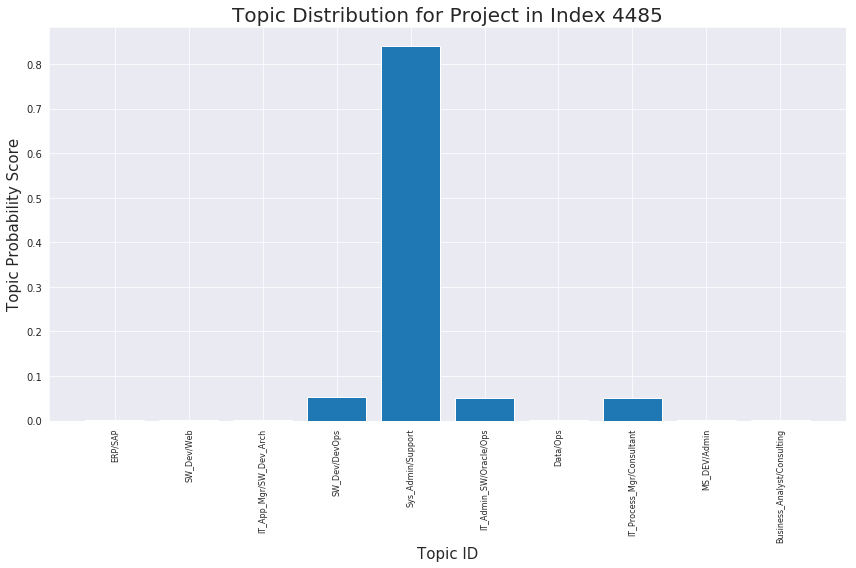

In [47]:
plot_topic_dist(doc_distribution, random_index)

In [50]:
lda_model =  models.LdaModel.load(os.path.join(outputDir, 'LDA_Approach_1.model'))

In [51]:
lda_model.show_topics()

[(0,
  '0.101*"entwicklung" + 0.068*"java" + 0.029*"application" + 0.024*"cloud" + 0.022*"spring" + 0.022*"agile" + 0.018*"scrum" + 0.017*"automate" + 0.015*"jenkins" + 0.015*"projekt"'),
 (1,
  '0.086*"data" + 0.055*"daten" + 0.039*"scrum" + 0.039*"entwicklung" + 0.033*"agile" + 0.032*"studio" + 0.028*"bi" + 0.028*"dsgvo" + 0.024*"berater" + 0.024*"big"'),
 (2,
  '0.080*"oracle" + 0.070*"sql" + 0.062*"linux" + 0.057*"administration" + 0.032*"db" + 0.032*"server" + 0.029*"system" + 0.027*"unix" + 0.024*"application" + 0.024*"skript"'),
 (3,
  '0.065*"operation" + 0.064*"windows" + 0.050*"administration" + 0.050*"server" + 0.048*"microsoft" + 0.045*"support" + 0.041*"system" + 0.040*"infrastructure" + 0.038*"application" + 0.031*"install"'),
 (4,
  '0.091*"management" + 0.040*"tech" + 0.036*"process" + 0.028*"operation" + 0.027*"analyst" + 0.025*"internal" + 0.023*"berater" + 0.023*"projekt" + 0.020*"concept" + 0.017*"planung"'),
 (5,
  '0.170*"entwicklung" + 0.048*"application" + 0.044

In [52]:
doc_distribution1 = np.array([topic[1] for topic in lda_model.get_document_topics(bow=bow)])
labels = np.argmax(doc_distribution1)
print(doc_distribution1)

[4.5254815e-04 4.5254815e-04 4.5254815e-04 5.4122273e-02 8.4001577e-01
 5.1445980e-02 4.5254815e-04 5.1700663e-02 4.5254815e-04 4.5254815e-04]
